In [3]:
#Load the excel file 
import pandas as pd

file_path = r"C:\Users\wujia\Desktop\SPH6004\Classify_AKI_Status_V3\1.sph6004_assignment1_data.xlsx"
df = pd.read_excel(file_path, engine="openpyxl")


##############EDA part 

In [4]:
#explore the dataset 
print(df.shape) #(50902，165)
print(df.info()) #'gender','race' - categorical data ,aki_stage / hospital_mortality(0=alive,1 = deceased): categorical data / bin age into different groups 
print(df.describe())

(50920, 165)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50920 entries, 0 to 50919
Columns: 165 entries, id to weight_admit
dtypes: float64(160), int64(3), object(2)
memory usage: 64.1+ MB
None
                 id  hospital_mortality     aki_stage  admission_age  \
count  5.092000e+04        50920.000000  50920.000000   50920.000000   
mean   3.498391e+07            0.102298      1.300393      64.942008   
std    2.893873e+06            0.303042      1.088128      17.278264   
min    3.000015e+07            0.000000      0.000000      18.002527   
25%    3.246663e+07            0.000000      0.000000      54.503884   
50%    3.498649e+07            0.000000      1.000000      66.713334   
75%    3.748413e+07            0.000000      2.000000      78.151289   
max    3.999981e+07            1.000000      3.000000     102.865603   

       heart_rate_min  heart_rate_max  heart_rate_mean       sbp_min  \
count    50841.000000    50841.000000     50841.000000  50823.000000   
mean   

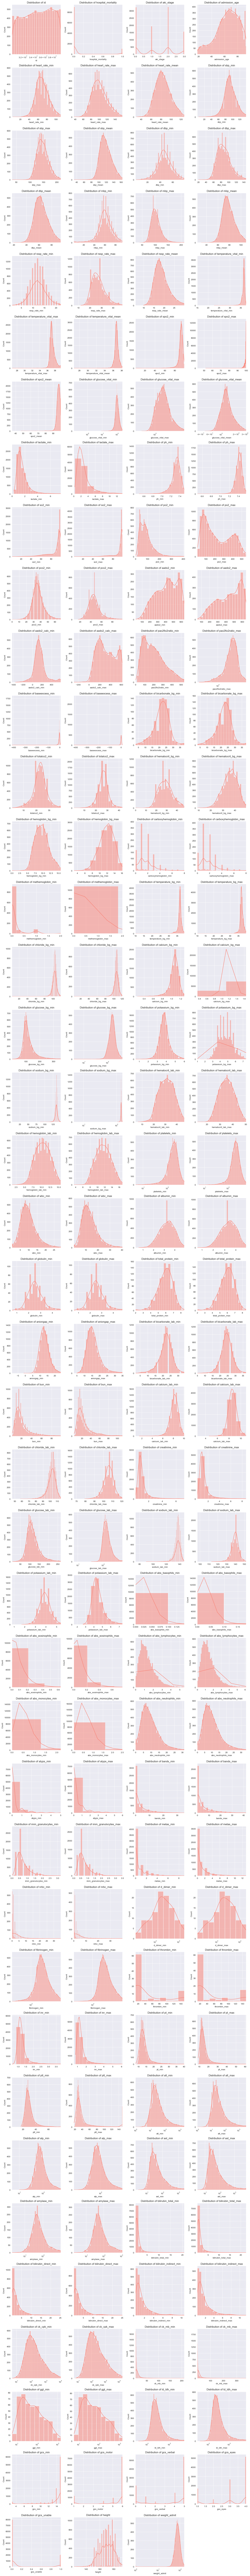

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

sns.set_style("darkgrid")

# Select all numerical columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Set number of subplots per row (Adjust for better visualization)
num_cols_per_row = 4  
num_features = len(num_cols)  # Get total number of features

# Dynamically calculate the number of required rows
num_rows = math.ceil(num_features / num_cols_per_row)

# Create the subplot grid
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(16, num_rows * 4))
axes = axes.flatten()  # Flatten to loop easily

for i, column in enumerate(num_cols):  
    ax = axes[i]  # Select subplot
    
    # Get min and max values
    min_val, max_val = df[column].min(), df[column].max()
    
    # If values vary widely, use log scale
    if max_val > 1000 and min_val > 0:  
        ax.set_xscale("log")
    
    # Auto-adjust bins based on range
    bin_count = 'auto' if max_val - min_val > 100 else 50

    # Sample data safely (Avoids ValueError)
    non_null_count = df[column].dropna().shape[0]
    sampled_data = df[column].dropna().sample(n=min(10000, non_null_count), random_state=42)
    
    # Ignore extreme outliers beyond the 99th percentile
    if len(sampled_data) > 0:  # Ensure there is data to compute percentiles
        upper_bound = np.percentile(sampled_data, 99)
    else:
        upper_bound = max_val  # Fallback to max value if all data is NaN
    
    # Plot histogram
    sns.histplot(sampled_data, kde=True, color="salmon", bins=bin_count, ax=ax)
    ax.set_xlim(min_val, upper_bound)  # Adjust x-axis to ignore extreme outliers
    ax.set_xlabel(column)
    ax.set_ylabel("Count")
    ax.set_title(f"Distribution of {column}")

# Hide empty subplots if any (Prevents blank plots)
for j in range(i + 1, len(axes)):  
    fig.delaxes(axes[j])

# Adjust layout for better visibility
plt.tight_layout()
plt.show()


In [6]:
# Calculate missing percentage for each column
missing_percentage_columns = (df.isnull().sum() / len(df)) * 100

# Display the missing values percentage
print(missing_percentage_columns)

missing_percentage_columns.to_excel("C:\\Users\\wujia\\Desktop\\SPH6004\\Classify_AKI_Status_V3\\2.missing_values.xlsx")




id                     0.000000
hospital_mortality     0.000000
aki_stage              0.000000
gender                 0.000000
admission_age          0.000000
                        ...    
gcs_verbal             1.007463
gcs_eyes               0.742341
gcs_unable             0.461508
height                50.881775
weight_admit           2.003142
Length: 165, dtype: float64


In [7]:
# Calculate the percentage of missing values for each patient (row)
# Add this feature to dataset 

# Calculate missing percentage for each patient (row)
df['missing_percentage'] = df.isnull().sum(axis=1) / df.shape[1] * 100

# Display the first few rows to verify
print(df[['missing_percentage']].head())

   missing_percentage
0           50.909091
1           50.303030
2           58.787879
3           52.121212
4           20.606061


In [8]:
####Based on literature review, add some important features for classify AKI status 
##New feature : BMI
if 'height' in df.columns and 'weight_admit' in df.columns:
    # Convert height from cm to meters
    df['height'] = df['height'] / 100

    # Calculate BMI
    df['BMI'] = df['weight_admit'] / (df['height'] ** 2)

    # Display the first few rows to verify
    print(df[['BMI']].head())

         BMI
0  17.053324
1        NaN
2        NaN
3  29.291249
4  26.370238


In [9]:
###Calculte eGFR using CKD-EPI equation
import numpy as np
import pandas as pd

def compute_egfr(creatinine_min, creatinine_max, gender, admission_age, race):
    """
    Calculate eGFR using the CKD-EPI equation, using creatinine_min for min_factor and creatinine_max for max_factor.

    Parameters:
    creatinine_min : Minimum serum creatinine (mg/dL)
    creatinine_max : Maximum serum creatinine (mg/dL)
    gender        : 'F' for female, 'M' for male
    admission_age : Age in years
    race         : 'BLACK/AF' for Black patients, otherwise 'Non-Black'

    Returns:
    Single eGFR value per patient
    """

    # Define kappa and alpha based on gender
    kappa = 0.7 if gender == 'F' else 0.9  
    alpha = -0.329 if gender == 'F' else -0.411  

    # Compute min(Scr/κ, 1) using creatinine_min
    min_factor = min(creatinine_min / kappa, 1) ** alpha

    # Compute max(Scr/κ, 1) using creatinine_max
    max_factor = max(creatinine_max / kappa, 1) ** -1.209

    # Compute eGFR formula
    egfr = 141 * min_factor * max_factor * (0.993 ** admission_age)

    # Apply multipliers for gender and race
    if gender == 'F':
        egfr *= 1.018
    if race == 'BLACK/AFRICAN AMERICAN':  # Assuming "BLACK" indicates Black race
        egfr *= 1.159


    return egfr


# Apply the eGFR calculation for each patient using dataset column names
df["eGFR"] = df.apply(lambda row: compute_egfr(row["creatinine_min"], row["creatinine_max"], row["gender"], row["admission_age"], row["race"]), axis=1)

# Save the updated dataset with eGFR values
output_file = r"C:\Users\wujia\Desktop\SPH6004\Classify_AKI_Status_V3\3.sph6004_assignment1_with_BMI_egfr.xlsx"
df.to_excel(output_file, index=False)

# Display first few rows
print(df[["creatinine_min", "creatinine_max", "eGFR"]].head())
#df.shape (50920, 168)

   creatinine_min  creatinine_max        eGFR
0             0.4             0.5  119.283124
1             2.2             2.3   23.073019
2             0.4             0.6  116.532183
3             0.8             0.8   88.242849
4             1.0             1.1   56.074630


In [10]:
###now my dataset df1 (is original dataset added with BMI, eGFR and missing Percentage for each patient)
df1 = df.copy()

# Drop the 'gender' and 'race' columns from the dataset, reduce categorical data since these informatin already incorporated into new features
df1 = df1.drop(columns=['race','gender'])

# Check the cleaned dataframe
print(df1.shape)


(50920, 166)


In [11]:
# Filter columns where the missing percentage is greater than 45%
columns_to_drop = missing_percentage_columns[missing_percentage_columns > 45].index.tolist()

# Drop these columns from the dataframe
df1= df1.drop(columns=columns_to_drop)
df1.shape 
df1.columns
# Save the updated DataFrame to a new Excel file at a specific location
file_path ="C:\\Users\\wujia\\Desktop\\SPH6004\\Classify_AKI_Status_V3\\4.sph6004_assignment1_removed_45_missing.xlsx"
df1.to_excel(file_path, index=False)
#df1.shape (50920, 89)

In [12]:
# Check missing percentages again
missing_check = (df1.isnull().sum() / len(df1)) * 100

# Identify columns that still have more than 45% missing
still_high_missing = missing_check[missing_check > 45].index.tolist()

# Print columns that should be removed
print("Columns still above 45% missing:", still_high_missing)

# If BMI is still in the list, remove it
df1 = df1.drop(columns=still_high_missing)

# Verify again
print("After removal, missing percentage:")
print((df1.isnull().sum() / len(df1)) * 100)


Columns still above 45% missing: ['BMI']
After removal, missing percentage:
id                    0.000000
hospital_mortality    0.000000
aki_stage             0.000000
admission_age         0.000000
heart_rate_min        0.155145
                        ...   
gcs_eyes              0.742341
gcs_unable            0.461508
weight_admit          2.003142
missing_percentage    0.000000
eGFR                  0.799293
Length: 88, dtype: float64


In [13]:
 # This is the MICE implementation to handle with missing number 
import pandas as pd
from fancyimpute import IterativeImputer  # This is the MICE implementation


# Create an imputer object using the MICE method
mice_imputer = IterativeImputer(max_iter=10, random_state=0)

# Fill the missing values in the dataframe
df1= pd.DataFrame(mice_imputer.fit_transform(df1), columns=df1.columns)

print(df1.isnull().sum()) 

id                    0
hospital_mortality    0
aki_stage             0
admission_age         0
heart_rate_min        0
                     ..
gcs_eyes              0
gcs_unable            0
weight_admit          0
missing_percentage    0
eGFR                  0
Length: 88, dtype: int64


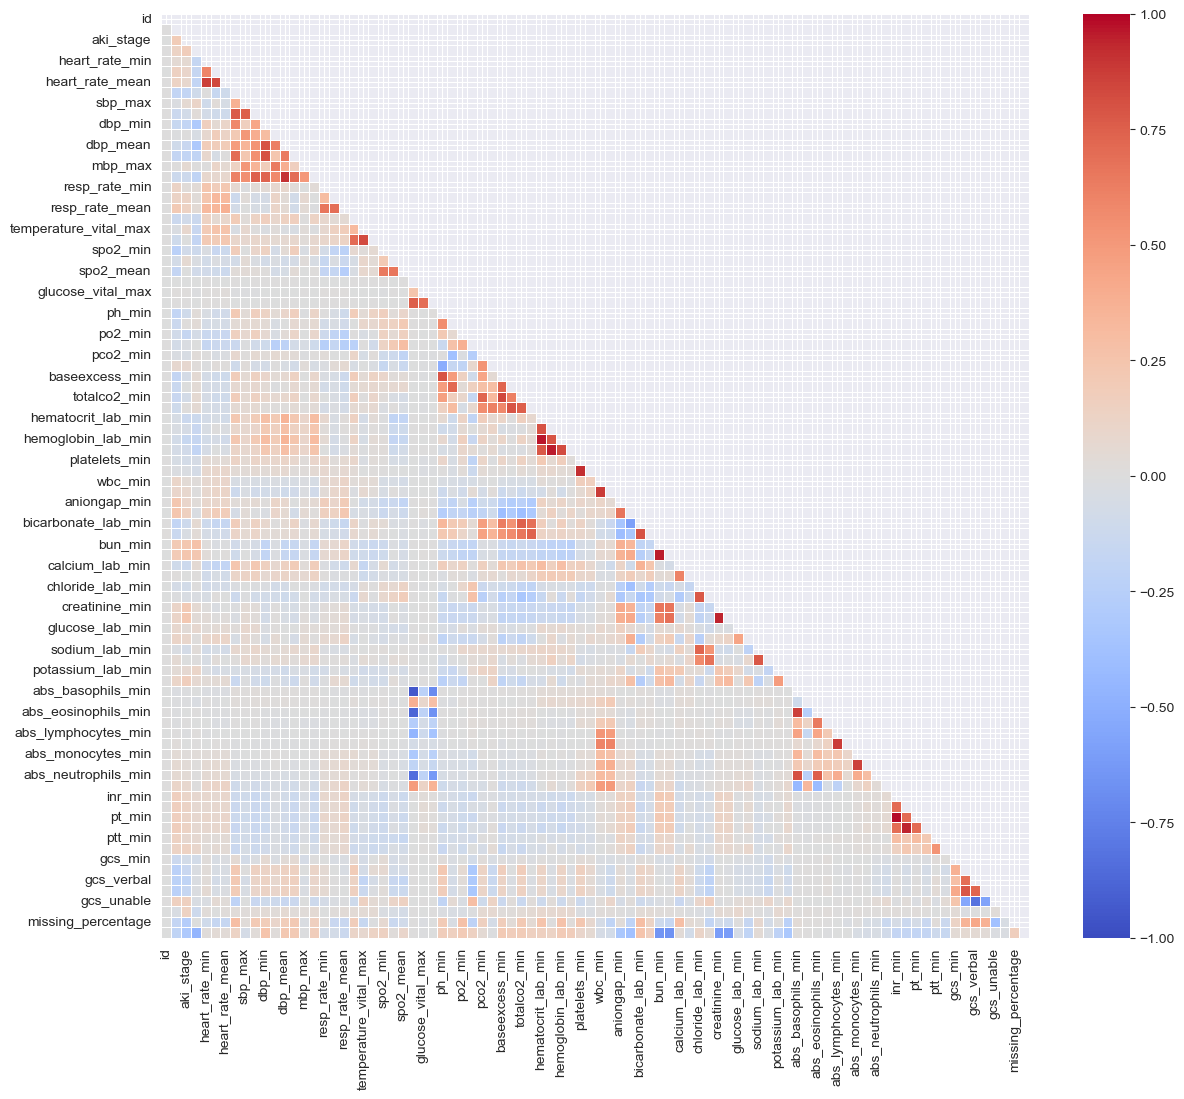

In [14]:
###Conduct a correlation test , heatmap 
import seaborn as sns
import matplotlib.pyplot as plt

# Create the correlation matrix
correlation_matrix = df1.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap with custom settings
plt.figure(figsize=(14, 12))  # Increase the figure size
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1,mask=mask)

# Display the plot
plt.show()

In [15]:
# Initialize the list to store highly correlated pairs
highly_correlated = []

# Iterate through the correlation matrix to find pairs with correlation > 0.8
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            highly_correlated.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Display the highly correlated pairs
print("Highly correlated pairs (correlation > 0.9):")
for pair in highly_correlated:
    print(f"{pair[0]} and {pair[1]}: {pair[2]}")
    #Yes, you are absolutely right! The presence of highly correlated features (correlation > 0.8) suggests multicollinearity


Highly correlated pairs (correlation > 0.9):
mbp_mean and dbp_mean: 0.9065144115952263
hemoglobin_lab_min and hematocrit_lab_min: 0.9658860714510187
hemoglobin_lab_max and hematocrit_lab_max: 0.9586567631056895
platelets_max and platelets_min: 0.9205753821360597
bun_max and bun_min: 0.9562551749867827
creatinine_max and creatinine_min: 0.9413687949428996
abs_basophils_min and glucose_vital_min: -0.9392300154317281
pt_min and inr_min: 0.98518661788533
pt_max and inr_max: 0.9406416485875619


In [16]:
# Define the list of highly correlated pairs (you can update this list based on your findings)
highly_correlated_pairs = [
    ('mbp_mean', 'dbp_mean'),
    ('hemoglobin_lab_min', 'hematocrit_lab_min'),
    ('hemoglobin_lab_max', 'hematocrit_lab_max'),
    ('platelets_max', 'platelets_min'),
    ('bun_max', 'bun_min'),
    ('creatinine_max', 'creatinine_min'),
    ('abs_basophils_min', 'glucose_vital_min'),
    ('pt_min', 'inr_min'),
    ('pt_max', 'inr_max')
]

# Identify features to remove (keeping the first feature in each pair)
to_remove = {pair[1] for pair in highly_correlated_pairs}

# Drop the selected features from df1
df2 = df1.drop(columns=to_remove, errors='ignore')





In [17]:
df2.shape

(50920, 79)

In [18]:
import pandas as pd
import scipy.stats as stats

# Define the target variables
targets = ['aki_stage', 'hospital_mortality']

# Dictionary to store correlation results
correlation_results = {}

# Iterate over each target variable
for target in targets:
    correlation_results[target] = {}

    # Iterate through numerical features
    for col in df2.select_dtypes(include=['float64', 'int64']).columns:
        if col != target:  # Exclude the target variable itself
            # Pearson correlation
            valid_rows = df1[[col, target]].dropna()
            if len(valid_rows) > 1:  # Ensure at least two valid data points
                corr, p_value = stats.pearsonr(valid_rows[col], valid_rows[target])
                correlation_results[target][col] = {'Correlation': corr, 'P-value': p_value}

# Convert results to DataFrame
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index').T

# Display correlation values and p-values in a more readable format
print("Correlation of features with AKI stage and hospital mortality:\n")
print(correlation_df.to_string(float_format="{:.4f}".format))  # Limiting decimal places for clarity

# Save results to Excel for further analysis
# Define the file path
file_path = r"C:\Users\wujia\Desktop\SPH6004\Classify_AKI_Status_V3\5.correlation_AKI_Hospital_Mortality.xlsx"
correlation_df.to_excel(file_path, index=True)

print(f"\nResults saved successfully at: {file_path}")


Correlation of features with AKI stage and hospital mortality:

                                                                                        aki_stage                                                         hospital_mortality
id                         {'Correlation': -0.0037499431845861688, 'P-value': 0.3974556038089978}     {'Correlation': 0.0037794573085215798, 'P-value': 0.39375133908989396}
hospital_mortality                            {'Correlation': 0.1932198676342955, 'P-value': 0.0}                                                                        NaN
admission_age                                 {'Correlation': 0.1726124597394286, 'P-value': 0.0}    {'Correlation': 0.12828442122276856, 'P-value': 9.267649506652817e-186}
heart_rate_min             {'Correlation': 0.05788194833623357, 'P-value': 4.761808768413671e-39}      {'Correlation': 0.05364496639784365, 'P-value': 8.94146776190768e-34}
heart_rate_max           {'Correlation': 0.10046511039959893, 'P-value'

In [19]:
# Define the significance threshold
p_threshold = 0.05

# Initialize an empty list for uncorrelated features
uncorrelated_features = []

# Iterate over each feature in the correlation dataframe
for feature in correlation_df.index:
    try:
        # Extract p-values safely
        p_value_aki = correlation_df.loc[feature, 'aki_stage']
        p_value_mortality = correlation_df.loc[feature, 'hospital_mortality']

        # If values are dictionaries, extract the p-value
        if isinstance(p_value_aki, dict):
            p_value_aki = p_value_aki.get('P-value', 1)
        if isinstance(p_value_mortality, dict):
            p_value_mortality = p_value_mortality.get('P-value', 1)

        # Check if both p-values are greater than the threshold
        if (p_value_aki > p_threshold) and (p_value_mortality > p_threshold):
            uncorrelated_features.append(feature)
    except Exception as e:
        print(f"Error processing feature {feature}: {e}")

# Display the list of features that are not significantly correlated with either outcome
print("Features with no significant correlation with AKI stage and hospital mortality:")
print(uncorrelated_features)

# Convert list to DataFrame and save to Excel for further analysis
uncorrelated_df = pd.DataFrame(uncorrelated_features, columns=['Uncorrelated Features'])
uncorrelated_df.to_excel("uncorrelated_features.xlsx", index=False)



Features with no significant correlation with AKI stage and hospital mortality:
['id', 'glucose_vital_mean']


In [20]:
uncorrelated_features = ['id', 'glucose_vital_mean']

# Create a new dataframe `df2` without these uncorrelated features
df3 = df2.drop(columns=uncorrelated_features, errors='ignore')

In [21]:
df3.shape


(50920, 77)

#########Prediction Models （AKI Stages Prediciton) 



In [22]:
# Import necessary libraries for Decision Tree
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
import warnings

warnings.filterwarnings("ignore")

# Step 1: Load Data
y = df3['aki_stage']  # Target variable
X = df3.drop(columns=['aki_stage'])  # Features

# Step 2: Split dataset into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Train Decision Tree Model 


#dt_model = DecisionTreeClassifier(random_state=42)   # Basic Parameters # Result : accuraacy : 0.37 / AUC : 0.56 
#Tuning with different parameters 

dt_model = DecisionTreeClassifier(
    max_depth=7,            
    min_samples_split=2,    
    min_samples_leaf=3,      
    class_weight='balanced', 
    random_state=42
) #Result: accuracy : 0.42 / AUC 0.68 


dt_model.fit(X_train, y_train)

# Step 4: Make Predictions
y_pred_dt = dt_model.predict(X_test)
y_prob_dt = dt_model.predict_proba(X_test)

# Step 5: Evaluate Performance
print("📌 Basic Decision Tree Performance:")
print(classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print(f"AUC Score: {roc_auc_score(y_test, y_prob_dt, average='macro', multi_class='ovr'):.4f}")



📌 Basic Decision Tree Performance:
              precision    recall  f1-score   support

         0.0       0.56      0.47      0.51      3372
         1.0       0.25      0.29      0.27      1968
         2.0       0.43      0.41      0.42      3257
         3.0       0.43      0.54      0.48      1587

    accuracy                           0.42     10184
   macro avg       0.42      0.43      0.42     10184
weighted avg       0.44      0.42      0.43     10184

Confusion Matrix:
 [[1580  738  807  247]
 [ 531  570  584  283]
 [ 573  763 1321  600]
 [ 121  242  370  854]]
AUC Score: 0.6804


########RandomForest-AKI Status

In [23]:
# Import necessary libraries (no scaler)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

# Step 1: Ensure `X_reduced` is ready (final dataset after feature selection)
y = df3['aki_stage']
X = df3.drop(columns=['aki_stage'])  # No scaling needed for tree-based models

# Step 2: Split dataset into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Train Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=200,        # Number of trees in the forest
    class_weight='balanced', # Handle class imbalance
    random_state=42
)
rf_model.fit(X_train, y_train)

# Step 4: Make Predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)

# Step 5: Evaluate Performance
print("📌 Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print(f"AUC Score: {roc_auc_score(y_test, y_prob_rf, average='macro', multi_class='ovr'):.4f}")


📌 Random Forest Performance:
              precision    recall  f1-score   support

         0.0       0.55      0.69      0.62      3372
         1.0       0.38      0.03      0.05      1968
         2.0       0.45      0.65      0.53      3257
         3.0       0.58      0.40      0.47      1587

    accuracy                           0.51     10184
   macro avg       0.49      0.44      0.42     10184
weighted avg       0.49      0.51      0.46     10184

Confusion Matrix:
 [[2342   41  899   90]
 [ 827   51  934  156]
 [ 886   26 2128  217]
 [ 175   16  763  633]]
AUC Score: 0.7240


For Logistic Regression, feature scaling is necessary because it relies on gradient-based optimization, which is sensitive to differences in feature scales. Without scaling, features with larger numerical values can dominate the model, leading to suboptimal performance.

In [24]:
# Import necessary libraries basic 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Suppress warnings for better readability
import warnings
warnings.filterwarnings("ignore")

# Step 1: Load Data
# Assuming df3 is your final cleaned dataset
y = df3['aki_stage']  # Target variable
X = df3.drop(columns=['aki_stage'])  # Features

# Step 2: Scale Data (Logistic Regression requires scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Split Dataset into Train & Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Train Basic Logistic Regression Model
model = LogisticRegression(multi_class='ovr', solver='saga', max_iter=500, random_state=42)
####model = LogisticRegression(solver='lbfgs', max_iter=100, random_state=42)  

model.fit(X_train, y_train)

# Step 5: Make Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)  # Get class probabilities

# Step 6: Evaluate Model Performance
print("📌 Logistic Regression Performance:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_prob, average='macro', multi_class='ovr'):.4f}")

📌 Logistic Regression Performance:
              precision    recall  f1-score   support

         0.0       0.53      0.72      0.61      3372
         1.0       0.32      0.01      0.01      1968
         2.0       0.45      0.62      0.52      3257
         3.0       0.56      0.40      0.46      1587

    accuracy                           0.50     10184
   macro avg       0.47      0.43      0.40     10184
weighted avg       0.47      0.50      0.44     10184

Confusion Matrix:
 [[2417    4  851  100]
 [ 897   11  900  160]
 [1006    8 2013  230]
 [ 271   11  676  629]]
AUC Score: 0.7133


In [25]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# Step 1: Ensure `X_reduced` is ready (final dataset after feature selection)
y = df3['aki_stage']
X = df3.drop(columns=['aki_stage'])

# Step 2: Standardize features (Tree models don't need it, but helps with consistency)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Split dataset into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


# Step 5: Train XGBoost Model
xgb_model = XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=6,scale_pos_weight=2,random_state=42) #scale_pos_weight=5, 
xgb_model.fit(X_train, y_train)


y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)

print("\n📌 XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print(f"AUC Score: {roc_auc_score(y_test, y_prob_xgb, average='macro', multi_class='ovr')}")



📌 XGBoost Performance:
              precision    recall  f1-score   support

         0.0       0.58      0.70      0.64      3372
         1.0       0.31      0.07      0.11      1968
         2.0       0.47      0.64      0.54      3257
         3.0       0.58      0.44      0.50      1587

    accuracy                           0.52     10184
   macro avg       0.49      0.46      0.45     10184
weighted avg       0.49      0.52      0.48     10184

Confusion Matrix:
 [[2376  114  793   89]
 [ 811  131  876  150]
 [ 763  127 2098  269]
 [ 150   49  684  704]]
AUC Score: 0.7432029941415487


##############Hospital Mortality 


In [26]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Step 1: Define Features and Target Variable
y = df3['hospital_mortality']
X = df3.drop(columns=['hospital_mortality'])

# Step 2: Split dataset into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Train Decision Tree Model
dt_model = DecisionTreeClassifier(
    class_weight={0:1, 1:5},  # Handle class imbalance
    min_samples_split=5,      # Minimum samples to split a node
    min_samples_leaf=2,       # Minimum samples in a leaf node
    max_depth=None,           # Allow full depth if needed
    random_state=42
)

dt_model.fit(X_train, y_train)

# Step 4: Predictions
y_pred_dt = dt_model.predict(X_test)
y_prob_dt = dt_model.predict_proba(X_test)  # Probabilities for each class

# Step 5: Evaluate Performance
print("📌 Decision Tree Performance:")
print(classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

# Step 6: Compute AUC Score Properly
if len(np.unique(y_test)) == 2:  # Binary Classification
    auc_score = roc_auc_score(y_test, y_prob_dt[:, 1])  # Use probability for class 1
else:  # Multi-Class Classification
    auc_score = roc_auc_score(y_test, y_prob_dt, average='macro', multi_class='ovr')

print(f"AUC Score: {auc_score:.4f}")


📌 Decision Tree Performance:
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92      9142
         1.0       0.36      0.41      0.38      1042

    accuracy                           0.86     10184
   macro avg       0.64      0.66      0.65     10184
weighted avg       0.87      0.86      0.87     10184

Confusion Matrix:
 [[8369  773]
 [ 615  427]]
AUC Score: 0.6650


In [27]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Step 1: Define Features and Target Variable
y = df3['hospital_mortality']
X = df3.drop(columns=['hospital_mortality'])

# Step 2: Standardize Features (SVM is sensitive to feature scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Split dataset into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Train SVM Model
svm_model = SVC(
    kernel='rbf',        # Radial Basis Function kernel (works well for non-linearly separable data)
    class_weight={0:1, 1:5},  # Handle class imbalance
    probability=True,    # Enable probability estimates for AUC calculation
    random_state=42
)

svm_model.fit(X_train, y_train)

# Step 5: Predictions
y_pred_svm = svm_model.predict(X_test)
y_prob_svm = svm_model.predict_proba(X_test)  # Probabilities for each class

# Step 6: Evaluate Performance
print("📌 SVM Performance:")
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

# Step 7: Compute AUC Score
if len(np.unique(y_test)) == 2:  # Binary Classification
    auc_score = roc_auc_score(y_test, y_prob_svm[:, 1])  # Use probability for class 1
else:  # Multi-Class Classification
    auc_score = roc_auc_score(y_test, y_prob_svm, average='macro', multi_class='ovr')

print(f"AUC Score: {auc_score:.4f}")


📌 SVM Performance:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      9142
         1.0       0.50      0.67      0.57      1042

    accuracy                           0.90     10184
   macro avg       0.73      0.80      0.76     10184
weighted avg       0.91      0.90      0.90     10184

Confusion Matrix:
 [[8446  696]
 [ 343  699]]
AUC Score: 0.9087


In [28]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Step 1: Define Features and Target Variable
y = df3['hospital_mortality']
X = df3.drop(columns=['hospital_mortality'])

# Step 2: Split dataset into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Train Random Forest Model
#rf_model = RandomForestClassifier(n_estimators=200, class_weight={0:1, 1:5}, random_state=42)

#rf_model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf_model = RandomForestClassifier(
    n_estimators=200,#increase to 500, more tree stabilize recall 
    class_weight={0:1, 1:5},  #result is similar to 'balance'
    min_samples_split=5,  # Try reducing from default (10-20 can work too)
    min_samples_leaf=2,    # Reduce to allow more depth
    max_depth=None,        # Allow full depth if needed# result will be better when set more depth
    random_state=42
)


rf_model.fit(X_train, y_train)

# Step 4: Predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)  # Probabilities for each class

# Step 5: Evaluate Performance
print("📌 Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# Step 6: Compute AUC Score Properly
if len(np.unique(y_test)) == 2:  # Binary Classification
    auc_score = roc_auc_score(y_test, y_prob_rf[:, 1])  # Use probability for class 1
else:  # Multi-Class Classification
    auc_score = roc_auc_score(y_test, y_prob_rf, average='macro', multi_class='ovr')

print(f"AUC Score: {auc_score:.4f}")

    


📌 Random Forest Performance:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96      9142
         1.0       0.81      0.28      0.41      1042

    accuracy                           0.92     10184
   macro avg       0.87      0.63      0.68     10184
weighted avg       0.91      0.92      0.90     10184

Confusion Matrix:
 [[9075   67]
 [ 754  288]]
AUC Score: 0.9122


In [29]:
# Import necessary libraries  (No PCA)
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Step 1: Ensure `X_reduced` is ready (should be your final cleaned dataset)
# Define target variable  
y = df2['hospital_mortality']  # Target variable

# Features after removing unwanted columns
X = df2.drop(columns=['hospital_mortality'])  # Drop the target variable from features

# Step 2: Standardize the dataset (Scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Fit & transform on entire feature set

# Step 3: Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Train Logistic Regression Model with L2 regularization (Ridge)
#model = LogisticRegression(penalty='l2', solver='saga', max_iter=1000, random_state=42)
model = LogisticRegression(penalty='l2', solver='saga', class_weight='balanced', max_iter=1000, random_state=42)#{0:1, 1:5}
#model = LogisticRegression(penalty='l2', solver='saga', class_weight={0:1, 1:5}, max_iter=1000, random_state=42)#{0:1, 1:5}

model.fit(X_train, y_train)

# Step 5: Predict and Evaluate the Model
y_pred = model.predict(X_test)  # Predict class labels
y_prob = model.predict_proba(X_test)  # Get class probabilities

# Print Classification Report and Confusion Matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Calculate AUC Score (Fix: Select only probability for class 1)
auc = roc_auc_score(y_test, y_prob[:, 1])
print(f"AUC: {auc:.4f}")  


Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.81      0.88      9142
         1.0       0.32      0.81      0.46      1042

    accuracy                           0.81     10184
   macro avg       0.65      0.81      0.67     10184
weighted avg       0.91      0.81      0.84     10184

Confusion Matrix:
 [[7374 1768]
 [ 200  842]]
AUC: 0.8867


Trade-Off: Precision vs. Recall
High Precision, Low Recall → Fewer false positives but misses real patients at risk.
High Recall, Low Precision → Catches most high-risk patients but may flag some healthy ones.
Since hospital mortality is a critical outcome, it's better to err on the side of recall (fewer false negatives), ensuring at-risk patients get more attention.



In [30]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Step 1: Define Features and Target Variable
y = df3['hospital_mortality']
X = df3.drop(columns=['hospital_mortality'])

# Step 2: Standardize features (Not necessary for trees but keeps consistency)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Split dataset into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Train XGBoost Model
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, scale_pos_weight=1, random_state=42)  #{0:1, 1:5}
xgb_model.fit(X_train, y_train)

# Step 5: Make Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)  # Get probabilities for both classes

# Step 6: Evaluate Model
print("\n📌 XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

# Step 7: Fix AUC Calculation (Use only probability for class 1)
auc_score = roc_auc_score(y_test, y_prob_xgb[:, 1])  # Corrected!
print(f"AUC Score: {auc_score:.4f}")  # Format to 4 decimal places

# model currently classifies hospital mortality as 1 when probability > 0.5.
#Lowering this slightly (e.g., 0.4 or 0.45) can increase recall while keeping precision high.



📌 XGBoost Performance:
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      9142
         1.0       0.72      0.42      0.53      1042

    accuracy                           0.92     10184
   macro avg       0.83      0.70      0.74     10184
weighted avg       0.92      0.92      0.91     10184

Confusion Matrix:
 [[8975  167]
 [ 605  437]]
AUC Score: 0.9304


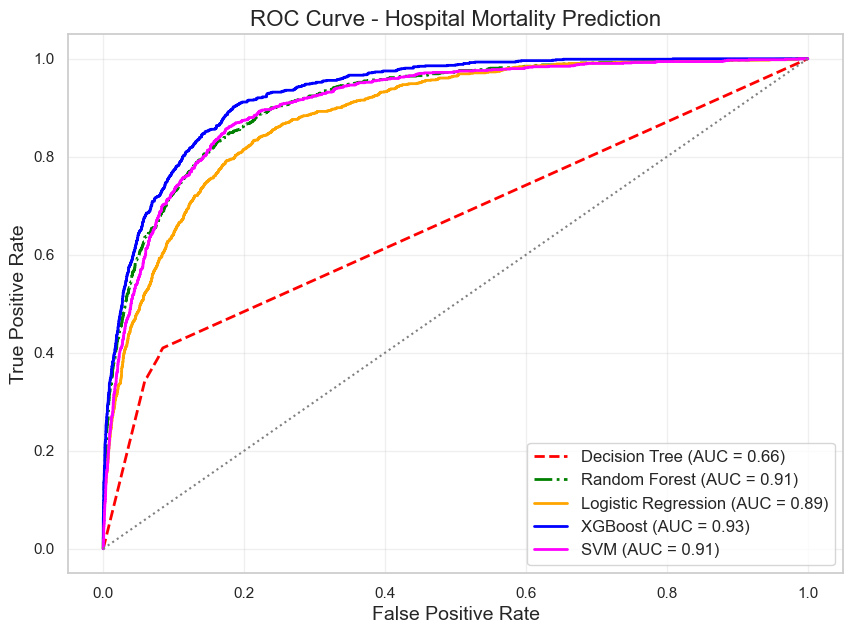

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Fix Probability Shapes
def fix_prob_shape(y_prob):
    if len(y_prob.shape) == 1:  # If 1D, convert to 2D
        y_prob = np.column_stack([1 - y_prob, y_prob])
    return y_prob[:, 1]

# Apply Fix to Models That Output 1D Probabilities
y_prob_dt = fix_prob_shape(y_prob_dt)
y_prob_rf = fix_prob_shape(y_prob_rf)
y_prob_xgb = fix_prob_shape(y_prob_xgb)

# Compute ROC curves
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
auc_dt = auc(fpr_dt, tpr_dt)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob[:, 1])  # Logistic Regression
auc_lr = auc(fpr_lr, tpr_lr)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm[:, 1])
auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC Curves
plt.figure(figsize=(10, 7))

plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})', 
         color='red', linestyle='--', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', 
         color='green', linestyle='-.', linewidth=2)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})', 
         color='orange', linestyle='-', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})', 
         color='blue', linestyle='-', linewidth=2)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})', 
         color='#FF00FF', linestyle='solid', linewidth=2)

# Add diagonal reference line
plt.plot([0, 1], [0, 1], linestyle='dotted', color='gray', linewidth=1.5)

# Labels and Title
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve - Hospital Mortality Prediction", fontsize=16)
plt.legend(fontsize=12, loc='lower right')

# Add grid and show the plot
plt.grid(alpha=0.3)
plt.show()
